<a href="https://colab.research.google.com/github/RozminWaghu99/Transaction_Fraud_Detection/blob/main/Transcation_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Transcation Fraud Detection¶
Problem Formulation
Due to the private nature of financial data, there is a lack of publicly available datasets that can be used for analysis. In this project, a synthetic dataset, publicly available on Kaggle, generated using a simulator called PaySim is used. The dataset was generated using aggregated metrics from the private dataset of a multinational mobile financial services company.

There are 6362620 instances of data set, The data set has 11 attributes which include is

Type of transactions
Amount transacted
Customer ID and Recipient ID
Old and New balance of Customer and Recipient
Time step of the transaction
Whether the transaction was fraudulent or not

# Problem Statement
Leverage the given data set to build an End-to-End Data Science Project and find whether a transaction is Fradulent or not.

# Hypothesis Generation
This is one of the important stages in any Data Science/Machine Learning pipeline. It involves understanding the problem in detail by brainstorming as many factors as possible which can impact the outcome. It is done by understanding the problem statement thoroughly and before looking at the data.

Below are some of the factors which I think can highly affect the target i.e. Fraudulent transaction:

Type of transaction: Based on the type (mode) of payment might impact the fradulent transaction.

Amount: The amount of transaction can decide the transaction is fradulent or not, we can find unusual activities through the amount of transaction.

Initial Balance and Balance left: By comparing account balances before the transcation and after transaction we might able to find whether there is unusual activity is happened or not

# Dataset description
* step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).
* type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
* amount - amount of the transaction in local currency.
* nameOrig - customer who started the transaction
* oldbalanceOrg - initial balance before the transaction
* newbalanceOrig - new balance after the transaction
* nameDest - customer who is the recipient of the transaction
* oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).
* newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).
* isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.
* isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

# Importing Library

In [37]:
import math
import numpy as np
import pandas as pd
from mlxtend.preprocessing import minmax_scaling
from scipy import stats as st


import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#Visualization libraries
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context({"figure.figsize": (15, 7.5)})

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
%matplotlib inline

import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
#for accuracy
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import recall_score, precision_score, f1_score, make_scorer
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import  ConfusionMatrixDisplay
import plotly.express as px
#handling imbalanced data
from imblearn.over_sampling import SMOTE
#best top 10 featur
from sklearn.metrics import plot_confusion_matrix, classification_report, plot_roc_curve
#saved
import pickle
import warnings
warnings.filterwarnings('ignore')
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Inspecting Fraud Data base

In [73]:
#Input (preserve original data in case we need to refer back to it at any point)
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ML Project/Transaction Fraud Detection/PS_20174392719_1491204439457_log.csv")
pd.set_option("display.max_columns", len(data.columns))
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [74]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


# Chechking Any missing data or NaN in the dataset?

In [40]:
print(str('Any missing data or NaN in the dataset:'),data.isnull().values.any())

Any missing data or NaN in the dataset: False


# **Exploratory Data Analysis**

# Inspect No. record and features

In [41]:
print("Number of records:\t\t",data.shape[0])
print("Number of features per record:\t",data.shape[1])

Number of records:		 6362620
Number of features per record:	 11


# Check % of No. of Valid and Fraud transactions

In [42]:
print("No. of Valid transactions (0):",data.isFraud.value_counts()[0],'which is ',round(data.isFraud.value_counts()[0]/data.shape[0] * 100,2),'%')
print("No. of Fraud transactions (1):",data.isFraud.value_counts()[1],'which is ',round(data.isFraud.value_counts()[1]/data.shape[0] * 100,2),'%')

No. of Valid transactions (0): 6354407 which is  99.87 %
No. of Fraud transactions (1): 8213 which is  0.13 %


# Check of No. of Valid and Fraud transactions

In [43]:
print("No of transactions Flagged as Valid (0) :",data.isFlaggedFraud.value_counts()[0])
print("No of transactions Flagged as Fraud (1) :",data.isFlaggedFraud.value_counts()[1])

No of transactions Flagged as Valid (0) : 6362604
No of transactions Flagged as Fraud (1) : 16


# Looking for mismatch in the balance at origin and destination after transaction?

In [75]:
print("Are there any mismatch in the balance at origin and destination after transaction?")
data['error_orig'] = (data["oldbalanceOrg"] - data["amount"] != data["newbalanceOrig"]).astype(int)
data['error_dest'] = (data["oldbalanceDest"] + data["amount"] != data["newbalanceDest"]).astype(int)

print("Balance Error(%) at the origin:",round(data['error_orig'].value_counts()[1]/data.shape[0] * 100,2))
print("Balance Error(%) at the destination:",round(data['error_dest'].value_counts()[1]/data.shape[0] * 100,2))

Are there any mismatch in the balance at origin and destination after transaction?
Balance Error(%) at the origin: 85.09
Balance Error(%) at the destination: 74.45


# Inspect transaction data with amount less than or equal to 0?

In [45]:
print("Any transaction with amount less than or equal to 0?")
print(len(data[data.amount<=0]))
print("What type of transactions are they?")
print(data[data.amount<=0]['type'].value_counts().index[0])
print("Are all these marked as Fraud Transactions?")
data[data.amount<=0]['isFraud'].value_counts()[1] == len(data[data.amount<=0])

Any transaction with amount less than or equal to 0?
16
What type of transactions are they?
CASH_OUT
Are all these marked as Fraud Transactions?


True

# Inspecting no. isFlaggedFraud and amount data

In [46]:
data_temp = data[data.isFlaggedFraud==1]
print("How many frauds transactions are Flagged?:")
print(len(data_temp))

print("What type of transactions are they?")
print(data_temp['type'].value_counts().index[0])

print("Are all these flagged also marked as Fraud Transactions?")
print(data_temp['isFraud'].value_counts()[1] == len(data_temp))

print("Minumum amount transfered in these transactions")
print(data_temp.amount.min())

print("Maximum amount transfered in these transactions")
print(data_temp.amount.max())

How many frauds transactions are Flagged?:
16
What type of transactions are they?
TRANSFER
Are all these flagged also marked as Fraud Transactions?
True
Minumum amount transfered in these transactions
353874.22
Maximum amount transfered in these transactions
10000000.0


In [47]:
print("No. of Valid transactions (0) ",data.isFraud.value_counts()[0],'which is ',round(data.isFraud.value_counts()[0]/data.shape[0] * 100,2),'%')
print("No. of Fraud transactions (1) ",data.isFraud.value_counts()[1],'which is ',round(data.isFraud.value_counts()[1]/data.shape[0] * 100,2),'%')

No. of Valid transactions (0)  6354407 which is  99.87 %
No. of Fraud transactions (1)  8213 which is  0.13 %


In [48]:
data = data.loc[(data['type'].isin(['TRANSFER', 'CASH_OUT']))]
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,...,newbalanceDest,isFraud,isFlaggedFraud,error_orig,error_dest
2,1,TRANSFER,181.00,C1305486145,181.0,...,0.00,1,0,0,1
3,1,CASH_OUT,181.00,C840083671,181.0,...,0.00,1,0,0,1
15,1,CASH_OUT,229133.94,C905080434,15325.0,...,51513.44,0,0,1,1
19,1,TRANSFER,215310.30,C1670993182,705.0,...,0.00,0,0,1,1
24,1,TRANSFER,311685.89,C1984094095,10835.0,...,2719172.89,0,0,1,1


# **Data Visualization**

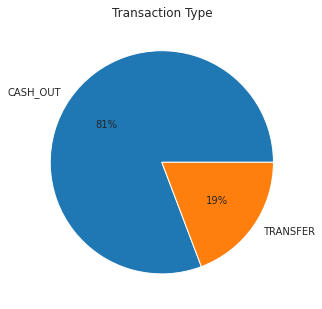

In [49]:
#create pie chart
plt.figure(figsize=(5,8))
plt.pie(data.type.value_counts().values,labels=data.type.value_counts().index,  autopct='%.0f%%')
plt.title("Transaction Type")
plt.show()

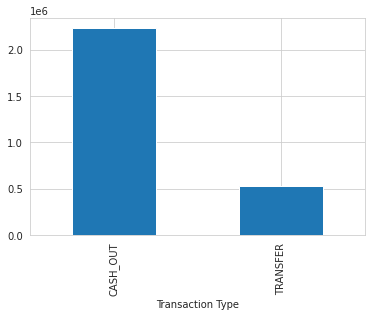

In [50]:
fraud = data['isFraud'].isin([0])
fraud_time = data[fraud].groupby(['type']).size().plot(kind='bar')
fraud_time.set_xlabel("Transaction Type")
plt.show()

**Split of Fraud Transactions by Transaction Type**

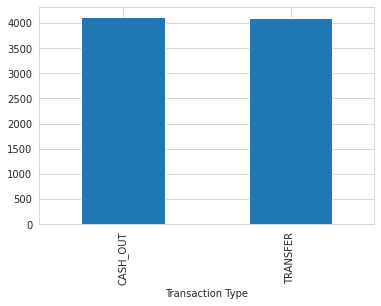

In [51]:
fraud = data['isFraud'].isin([1])
fraud_time = data[fraud].groupby(['type']).size().plot(kind='bar')
fraud_time.set_xlabel("Transaction Type")
plt.show()

Split of Fraud Transactions by Transaction Type

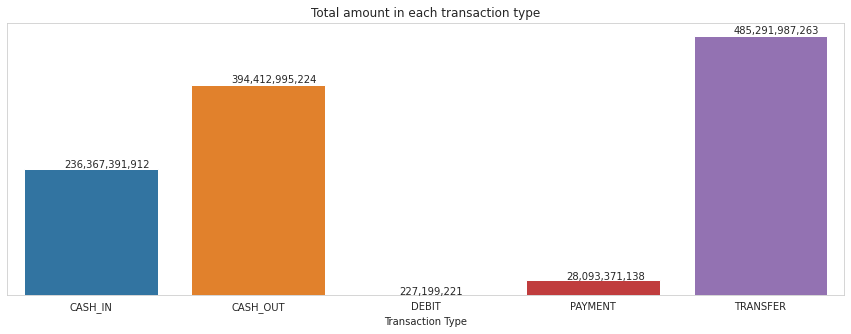

In [77]:
d = data.groupby('type')['amount'].sum()
plt.figure(figsize=(15,5))
ax = sns.barplot(x=d.index,y=d.values)
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x()+0.24, p.get_height()*1.01))
    
plt.title("Total amount in each transaction type")
plt.yticks([])
plt.xlabel("Transaction Type")
plt.show()

**Fraud Transactions by Transaction Type**

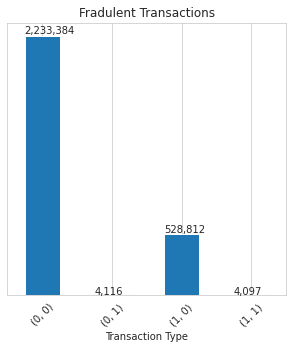

In [70]:
plt.figure(figsize=(5,5))
ax = data.groupby(['type','isFraud']).size().plot(kind='bar')

for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))
plt.title("Fradulent Transactions")
plt.xlabel("Transaction Type")
plt.yticks([])
plt.xticks(rotation=45)
plt.show()

# Label Encoding for object to numeric conversion

In [54]:
objList = data.select_dtypes(include = "object").columns

le = LabelEncoder()

for feat in objList:
    data[feat] = le.fit_transform(data[feat].astype(str))

print (data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2770409 entries, 2 to 6362619
Data columns (total 13 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            int64  
 2   amount          float64
 3   nameOrig        int64  
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        int64  
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
 11  error_orig      int64  
 12  error_dest      int64  
dtypes: float64(5), int64(8)
memory usage: 295.9 MB
None


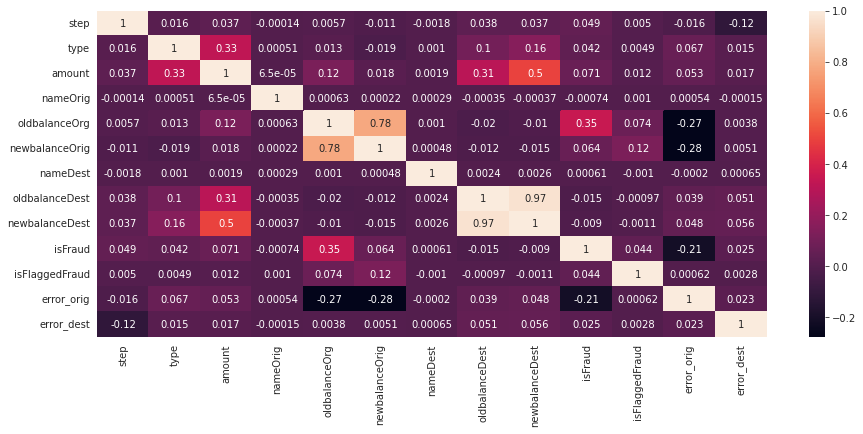

In [55]:
corr=data.corr()
plt.figure(figsize=(15,6))
sns.heatmap(corr,annot=True)

# Data cleaning including outliers. 

Text(0.5, 1.0, 'Amount box plot')

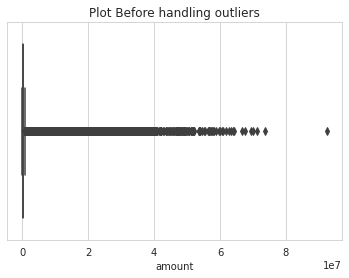

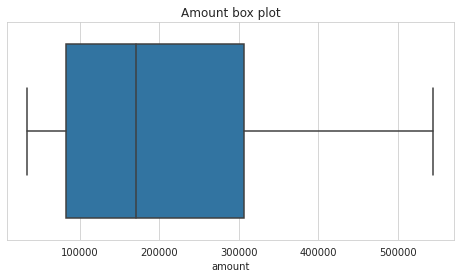

In [56]:
sns.boxplot(data['amount'])
plt.title("Plot Before handling outliers")
# Computing 10th, 90th percentiles and replacing the outliers
tenth_percentile = np.percentile(data.amount, 10)
ninetieth_percentile = np.percentile(data.amount, 90)
# print(tenth_percentile, ninetieth_percentile)
data['amount'] = np.where(data.amount<tenth_percentile, tenth_percentile, data.amount)
data['amount'] = np.where(data['amount']>ninetieth_percentile, ninetieth_percentile, data['amount'])
plt.figure(figsize=(8,4))
sns.boxplot(data['amount'])
plt.title("Plot After handling outliers")
plt.title("Amount box plot")

# Data cleaning including MULTICOLINEARITY

In [57]:
# Import library for VIF (VARIANCE INFLATION FACTOR)
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(data):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = data.columns
    vif["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]

    return(vif)

calc_vif(data)

,variables,VIF
0,step,3.513442
1,type,1.706589
2,amount,4.194175
3,nameOrig,3.580319
4,oldbalanceOrg,3.485453
5,newbalanceOrig,3.052719
6,nameDest,3.580585
7,oldbalanceDest,21.713842
8,newbalanceDest,22.870331
9,isFraud,1.339878


In [58]:
data['Actual_amount_orig'] = data.apply(lambda x: x['oldbalanceOrg'] - x['newbalanceOrig'],axis=1)
data['Actual_amount_dest'] = data.apply(lambda x: x['oldbalanceDest'] - x['newbalanceDest'],axis=1)
data['Transaction_Path'] = data.apply(lambda x: x['nameOrig'] + x['nameDest'],axis=1)

#Dropping columns
data = data.drop(['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','step','nameOrig',
                  'nameDest','error_orig','error_dest'],axis=1)
calc_vif(data)

,variables,VIF
0,type,1.693235
1,amount,3.145211
2,isFraud,1.300102
3,isFlaggedFraud,1.002574
4,Actual_amount_orig,1.356664
5,Actual_amount_dest,1.243021
6,Transaction_Path,2.094893


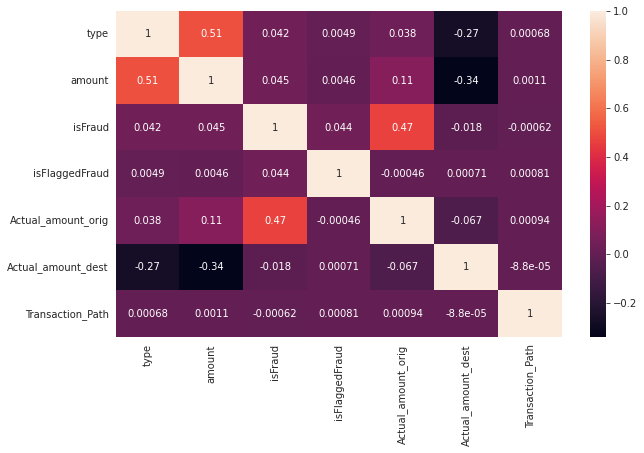

In [59]:
corr=data.corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr,annot=True)

# NORMALIZING (SCALING) AMOUNT

In [60]:
# Perform Scaling
scaler = StandardScaler()
data["NormalizedAmount"] = scaler.fit_transform(data["amount"].values.reshape(-1, 1))
data.drop(["amount"], inplace= True, axis= 1)

# Select variables to be included in the model

Using the VIF values and correlation heatmap. We just need to check if there are any two attributes highly correlated to each other and then drop the one which is less correlated to the isFraud Attribute.

# Define dependent and independent variables and then split the data into a training set and testing set.

In [61]:
X=data.copy()
y=X.pop('isFraud')
y.value_counts()

0    2762196
1       8213
Name: isFraud, dtype: int64

There is almost a 99% - 0.1% distribution of the Target values which seems data is highly unbalanced
To deal with imbalanced data we will use class_weights as this is a finance dataset, because for the finance dataset if use oversampling or undersampling or smote they will create fake data points or duplicate data points, in the financial problems we need accurate information otherwise it will mislead us and we may end up with a bad model.

# Handling imbalance data

In [62]:
#handling imbalance data
from imblearn.over_sampling import SMOTE 
smot = SMOTE(sampling_strategy='minority') 
X, y = smot.fit_resample(X, y) 
y.value_counts()

1    2762196
0    2762196
Name: isFraud, dtype: int64

In [63]:
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
print('Total no. of samples: Training and Testing dataset separately!')
print('X_train:', np.shape(X_train))
print('y_train:', np.shape(y_train))
print('X_test:', np.shape(X_test))
print('y_test:', np.shape(y_test))

Total no. of samples: Training and Testing dataset separately!
X_train: (4419513, 6)
y_train: (4419513,)
X_test: (1104879, 6)
y_test: (1104879,)


# Model Development and Prediction  

In [64]:
regressors = {
    "GaussianNB": GaussianNB(),
    "LogisticRegression": LogisticRegression(),
    "RandomForestClassifier":RandomForestClassifier(n_estimators= 1, criterion="entropy")
    }
df_models = pd.DataFrame(columns=['model', 'run_time', 'rmse'])
for key in regressors:

    print('*',key)
    start_time = time.time()
    regressor = regressors[key]
    model = regressor.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores = cross_val_score(model, X_train, y_train,scoring="neg_mean_squared_error", cv=5)
    row = {'model': key,
           'run_time': format(round((time.time() - start_time)/60,2)),
           'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
           'accuracy': np.mean(accuracy_score(y_test,y_pred)),
    }

    df_models = df_models.append(row, ignore_index=True)

* GaussianNB
* LogisticRegression
* RandomForestClassifier


In [65]:
df_models.head().sort_values(by='rmse', ascending=True)

,model,run_time,rmse,accuracy
2,RandomForestClassifier,2.06,0.182853,0.966565
1,LogisticRegression,1.44,0.300039,0.909977
0,GaussianNB,0.12,0.433332,0.812224


# CONCLUSION

We have seen that Accuracy of both  Decision Tree is more.

# ROC Curve
Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity.

Prediction [0 1 0 ... 1 1 0]


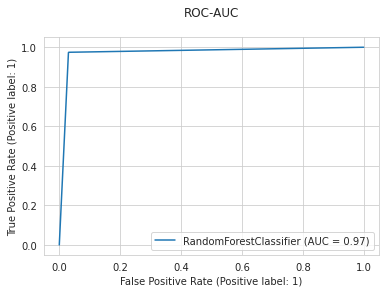

In [66]:
RT_model=RandomForestClassifier(n_estimators= 1, criterion="entropy")
RT_model.fit(X_train, y_train,)
ypred=RT_model.predict(X_test)
print("Prediction",ypred)

plot_roc_curve(RT_model, X_test, y_test)
plt.title('ROC-AUC\n')
plt.show()

We get ROC AUC is 98%.that is best fitted model to predict fraud

# Confusion Matrix Evaluation Metrics

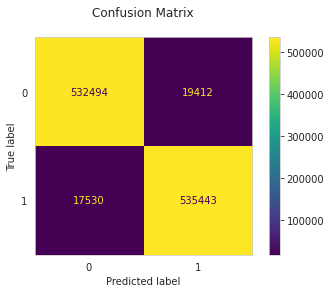

In [67]:
plot_confusion_matrix(model, X_test, y_test)
plt.title('Confusion Matrix\n')
plt.grid(visible=None)
plt.show()

# Evaluate the model using a classification report to obtain an accuracy rate.

In [68]:
print("Classification Report:\n\n", classification_report(y_test, y_pred))

Classification Report:

               precision    recall  f1-score   support

           0       0.97      0.96      0.97    551906
           1       0.97      0.97      0.97    552973

    accuracy                           0.97   1104879
   macro avg       0.97      0.97      0.97   1104879
weighted avg       0.97      0.97      0.97   1104879



# What are the key factors that predict fraudulent customer?
Customer's identity (email addresses, credit card numbers, etc.)
Their preferred payment methods,
The source of request is secured or not
Their network (emails, phone numbers, and payment details entered with the online account),
The past order details.


# Do these factors make sense? If yes, How? If not, How not?
Yes. we close look EDA and we conculde that all selected factors are affected.

# What kind of prevention should be adopted while company update its infrastructure?
* Setting the right risk threshold for your business
* screen public records of the user that might have been published in a given time period against the applicant
* Secure Infrastructure : Secure infrastructure implies the database systems and servers where data is stored and the boundaries established to secure these. Production data is usually encrypted in any core banking system. If required for testing, it is mandatory that important data like bank account number, customer name, and address be masked. Access to production systems is restricted. Vendors who deal with infrastructure are generally different from those who deal with applications. Bank employees are usually given special equipment where access to social websites, personal emails, and USB ports is blocked. Employees can only access the banks’ network over a VPN when using public Wi-Fi.
* Secure Processes : Banks have established many processes to ensure that security is implemented and tested. This includes KYC (Know Your Customer) updates for customers, NDA (Non-disclosure agreement) for employees and vendors, securing special zones within the premises and remote data centers.
* Continuous Communication : Banks also communicate regularly with consumers on upgrades to systems, the introduction of new authentication procedures, etc., in addition to the periodic account statements that are generated and sent to customers. Customers can also set limits and alerts based on different conditions to ensure that they are informed if any unexpected activity takes place concerning their accounts. While there are multiple channels of communication available, the set-up is flexible to cater to customers’ convenience.

# Assuming these actions have been implemented, how would you determine if they work?
* Bank sending E-statements.
* Customers keeping a check of their account activity.
* Always keep a log of your payments.